<a href="https://colab.research.google.com/github/zuo-liangliang/DeepLearning-check2023-2024/blob/FEDRT-LSTM_TSET-use-zhangmeng-2024.04.24/Result_528TRAIN-zhangmengTEST_22.62%25_epoch200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/MyDrive/NTU-Fi_HAR.zip" -d "/content/drive/MyDrive/check_yjf_2024.04.10/WiFi-CSI-Sensing-Benchmark-main/NTU-Fi_HAR/"
# 解压Zip文件到指定路径
################################################################################################################################

In [50]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [51]:
################################################################################################################################
##############验证程序############验证程序###########验证程序##############验证程序########验证程序###########验证程序###########
################################################################################################################################
!pip install einops
# !pip install torch==1.12.0 torchvision==0.13.0
import torch
import torchvision
#!pip install torch torchvision torchaudio
print("PyTorch 版本:", torch.__version__)
print("TorchVision 版本:", torchvision.__version__)


ERROR: Operation cancelled by user
PyTorch 版本: 2.2.1+cu121
TorchVision 版本: 0.17.1+cu121


In [52]:
import os
path = "/content/drive/MyDrive/Result_FEDRT-LSTM_TSET-use-zhangmeng"
os.chdir(path)
print(os.getcwd())
# 更改运行目录，定位当前运行地址

/content/drive/MyDrive/Result_FEDRT-LSTM_TSET-use-zhangmeng


In [59]:
# FEDRT-LSTM
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from __future__ import print_function

import time
import os,sys
import numpy as np
import pandas as pd
import scipy.io as scio
import tensorflow as tf
tf.compat.v1.keras.backend.set_session
import keras
from keras.layers import Input, GRU, LSTM, Dense, Flatten, Dropout, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, TimeDistributed
from keras.models import Model, load_model
import keras.backend as K
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.layers import MultiHeadAttention, LayerNormalization
num_transformer_layers = 1  # 设置Transformer层数

# Parameters
use_existing_model = False  # 创建一个模型（False）默认创建一个新模型
# use_existing_model = True    # 模型权重修改点 使用已经存在的模型（True）
# data_dir = '/content/drive/MyDrive/Colab_Notebooks/528BVP-acnt2/528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4/'   #修改数据集文件夹
data_dir_training = '/content/drive/MyDrive/Result_FEDRT-LSTM_TSET-use-zhangmeng/528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4/'
data_dir_testing = '/content/drive/MyDrive/Result_FEDRT-LSTM_TSET-use-zhangmeng/DriverBVP[-1,1]bvplength20-分辨率15-手势4/'  # 修改为另外环境下的数据路径

#fraction_for_test = 0.1 # 修改测试集占比 原先是0.1-->0.2
#ALL_MOTION = [1,2,3,4,5,6]
ALL_MOTION = [2,3,4,5]  # 这部分还可以改？
N_MOTION = len(ALL_MOTION)
T_MAX = 0
n_epochs = 200 #200       #原始是30 #修改点1 取在528上最好的一组超参
f_dropout_ratio = 0.5
n_gru_hidden_units = 32
n_batch_size = 32     #原始是32-->16
f_learning_rate = 0.001  #原始是0.001-->0.002

def normalize_data(data_1):
    data_1_max = np.concatenate((data_1.max(axis=0),data_1.max(axis=1)),axis=0).max(axis=0)
    data_1_min = np.concatenate((data_1.min(axis=0),data_1.min(axis=1)),axis=0).min(axis=0)
    if (len(np.where((data_1_max - data_1_min) == 0)[0]) > 0):
        return data_1
    data_1_max_rep = np.tile(data_1_max,(data_1.shape[0],data_1.shape[1],1))
    data_1_min_rep = np.tile(data_1_min,(data_1.shape[0],data_1.shape[1],1))
    data_1_norm = (data_1 - data_1_min_rep) / (data_1_max_rep - data_1_min_rep)
    return  data_1_norm

def zero_padding(data, T_MAX):
    data_pad = []
    for i in range(len(data)):
        t = np.array(data[i]).shape[2]
        data_pad.append(np.pad(data[i], ((0,0),(0,0),(T_MAX - t,0)), 'constant', constant_values = 0).tolist())
    return np.array(data_pad)

def onehot_encoding(label, num_class):
    label = np.array(label).astype('int32')
    label = np.squeeze(label)
    # _label = np.eye(num_class)[label-1]     # from label to onehot
    _label = np.eye(num_class)[label-2]   #修改点2
    return _label

def load_data(path_to_data, motion_sel):
    global T_MAX
    data = []
    label = []
    for data_root, data_dirs, data_files in os.walk(path_to_data):
        for data_file_name in data_files:
            file_path = os.path.join(data_root,data_file_name)
            try:
                data_1 = scio.loadmat(file_path)['velocity_spectrum_ro']
                label_1 = int(data_file_name.split('-')[1])
                #repetition = int(data_file_name.split('-')[4])
                repetition = int(data_file_name.split('-')[2])  #修改点3
                # Select Motion
                if (label_1 not in motion_sel):
                    continue
                data_normed_1 = normalize_data(data_1)
                if T_MAX < np.array(data_1).shape[2]:
                    T_MAX = np.array(data_1).shape[2]
            except Exception:
                continue
            # Save List
            data.append(data_normed_1.tolist())
            label.append(label_1)
                # Zero-padding
    data = zero_padding(data, T_MAX)

    # Swap axes
    data = np.swapaxes(np.swapaxes(data, 1, 3), 2, 3)   # [N,20,20',T_MAX]=>[N,T_MAX,20,20']
    data = np.expand_dims(data, axis=-1)    # [N,T_MAX,20,20]=>[N,T_MAX,20,20,1]

    # Convert label to ndarray
    label = np.array(label)

    # data(ndarray): [N,T_MAX,20,20,1], label(ndarray): [N,N_MOTION]
    return data, label

# 构建符合输入形状为 (None, 20, 15, 15, 1) 和输出形状为 (None, 4) 的  模型：
#加Transformer修改点3
def transformer_layer(inputs, hidden_units, dropout_rate):
    # Self-attention
    attention_output = MultiHeadAttention(
        num_heads=8, key_dim=hidden_units // 8
    )(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization()(attention_output + inputs)

    # Feed-forward network
    ffn = Dense(hidden_units, activation="relu")(attention_output)
    ffn = Dense(hidden_units)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    ffn = LayerNormalization()(ffn)

    return ffn

#加Transformer修改点4
def assemble_model(input_shape, n_class):
    model_input = Input(shape=input_shape, dtype='float32', name='name_model_input')    # (@,T_MAX,20,20,1)

    # Feature extraction part
    x = TimeDistributed(Conv2D(16,kernel_size=(5,5),activation='relu',data_format='channels_last',\
        input_shape=input_shape))(model_input)   # (@,T_MAX,20,20,1)=>(@,T_MAX,16,16,16)
    x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)    # (@,T_MAX,16,16,16)=>(@,T_MAX,8,8,16)
    x = TimeDistributed(Flatten())(x)   # (@,T_MAX,8,8,16)=>(@,T_MAX,8*8*16)
    x = TimeDistributed(Dense(64,activation='relu'))(x) # (@,T_MAX,8*8*16)=>(@,T_MAX,64)
    x = TimeDistributed(Dropout(f_dropout_ratio))(x)
    x = TimeDistributed(Dense(64,activation='relu'))(x) # (@,T_MAX,64)=>(@,T_MAX,64)

    # Add transformer layers
    for _ in range(num_transformer_layers):
        x = transformer_layer(x, hidden_units=64, dropout_rate=f_dropout_ratio)  # 修改点1
    x = LSTM(n_gru_hidden_units,return_sequences=False)(x)  # (@,T_MAX,64)=>(@,128)
    x = Dropout(f_dropout_ratio)(x)
    model_output = Dense(n_class, activation='softmax', name='name_model_output')(x)  # (@,128)=>(@,n_class)

    # Create the model
    # Model compiling
    model = Model(inputs=model_input, outputs=model_output)
    model.compile(optimizer=keras.optimizers.RMSprop(lr=f_learning_rate),
                    loss='mean_squared_error',  # 将损失函数改为均方误差
                    metrics=['accuracy']
                )
    return model

model_type = 'FEDRT-LSTM'

# 创建结果文件夹
result_folder = f'Result_528TRAIN-zhangmengTEST'
os.makedirs(result_folder, exist_ok=True)


No GPU available

Loaded dataset of 1120 samples, each sized (20, 15, 15, 1)



Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 name_model_input (InputLay  [(None, 20, 15, 15, 1)]      0         []                            
 er)                                                                                              
                                                                                                  
 time_distributed_78 (TimeD  (None, 20, 11, 11, 16)       416       ['name_model_input[0][0]']    
 istributed)                                                                                      
                                                                                                  
 time_distributed_79 (TimeD  (None, 20, 5, 5, 16)         0         ['time_distributed_78[0][0]'] 
 istributed)                                                                               

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Loaded dataset of 84 samples, each sized (20, 15, 15, 1)

3/3 [==============================] - 1s 12ms/step


<ipython-input-60-a2ea4c6f219f>:95: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]


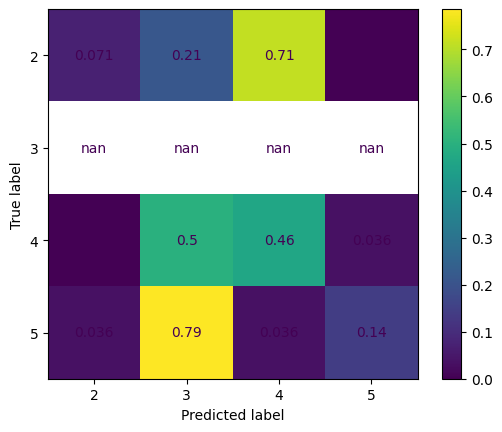

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           2     0.6667    0.0714    0.1290        28
           3     0.0000    0.0000    0.0000         0
           4     0.3824    0.4643    0.4194        28
           5     0.8000    0.1429    0.2424        28

    accuracy                         0.2262        84
   macro avg     0.4623    0.1696    0.1977        84
weighted avg     0.6163    0.2262    0.2636        84

0.2261904761904762
22.62%


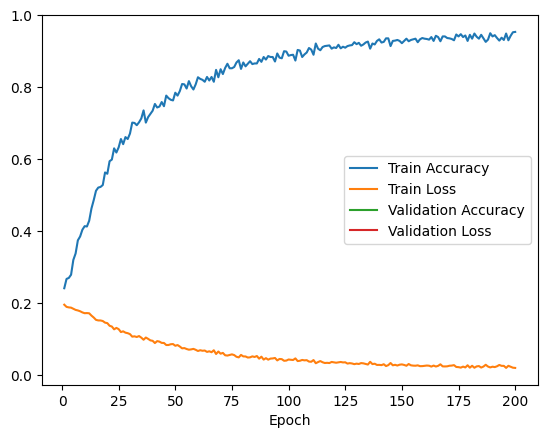

程序执行时间为：275.31秒


In [60]:
# Let's BEGIN >>>>

# 定义版本
today_version = '2024.04.24_v0.3'

import time
start_time = time.time()  # 记录程序开始时间

# 获取可见的 GPU 设备列表
visible_gpus = tf.config.experimental.list_physical_devices('GPU')
if len(visible_gpus) > 0:
    # 如果有可见的 GPU 设备，设置 TensorFlow 在 GPU 上运行
    tf.config.set_visible_devices(visible_gpus, 'GPU')
    gpu_config = tf.config.experimental.set_memory_growth(visible_gpus[0], True)
    sess = tf.compat.v1.Session(config=gpu_config)
    tf.compat.v1.keras.backend.set_session(sess)
    print('GPU available')
else:
    # 如果没有可见的 GPU 设备，设置 TensorFlow 在 CPU 上运行
    tf.config.set_visible_devices([], 'GPU')
    sess = tf.compat.v1.Session()
    print('No GPU available')

# 加载训练集数据
train_data, train_label = load_data(data_dir_training, ALL_MOTION)
print('\nLoaded dataset of ' + str(train_label.shape[0]) + ' samples, each sized ' + str(train_data[0,:,:].shape) + '\n')

# One-hot encoding for train data
train_label = onehot_encoding(train_label, N_MOTION)

##############################################################################
# Load data
# data, label = load_data(data_dir, ALL_MOTION)
# print('\nLoaded dataset of ' + str(label.shape[0]) + ' samples, each sized ' + str(data[0,:,:].shape) + '\n')

# Split train and test
# [data_train, data_test, label_train, label_test] = train_test_split(data, label, test_size=fraction_for_test)
# print('\nTrain on ' + str(label_train.shape[0]) + ' samples\n' +\
    # 'Test on ' + str(label_test.shape[0]) + ' samples\n')

# One-hot encoding for train data
# label_train = onehot_encoding(label_train, N_MOTION)

# Load or fabricate model
if use_existing_model:
    model = load_model('model_Transformer_MultiAttention_LSTM_mse_1层Transformer_epoch200_86.61%.h5')
    # model = load_model('model_LSTM_91.07_best_trained.h5')
    # model = load_model('model_MultiAttention_LSTM_1层Transformer_MSE_epoch200_BS32_lr0.001_86.61%.h5')
    # model = load_model('MultiAttention_LSTM_mse_1层Transformer_epoch50_79.46%.h5')
    model.summary()
else:
    model = assemble_model(input_shape=(T_MAX, 15, 15, 1), n_class=N_MOTION) #修改点4
    model.summary()

class AccuracyLossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_acc = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs.get('accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.val_loss.append(logs.get('val_loss'))

history = AccuracyLossHistory()

# model.fit({'name_model_input': data_train},{'name_model_output': label_train},
model.fit({'name_model_input': train_data},{'name_model_output': train_label},
          batch_size=n_batch_size,
          epochs=n_epochs,
          verbose=1,
          # validation_split=0.1,
          shuffle=True, callbacks=[history])
print('Saving trained model...')
#model.save('model_widar3_trained.h5')
model.save(f'{result_folder}/{today_version}_FEDRT-LSTM-train-model.h5')  # 改动

# Testing...
print('Testing...')

# 加载测试集数据
test_data, test_label = load_data(data_dir_testing, ALL_MOTION)
print('\nLoaded dataset of ' + str(test_label.shape[0]) + ' samples, each sized ' + str(test_data[0,:,:].shape) + '\n')

label_test_pred = model.predict(test_data)
# label_test_pred = np.argmax(label_test_pred, axis = -1) + 2 #修改点5
label_test_pred = np.argmax(label_test_pred, axis = -1) + 2 #修改点5 2024.04.24修改

# Confusion Matrix
cm = confusion_matrix(test_label, label_test_pred)
# print(cm)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
# cm = np.around(cm, decimals=2) # 保留几位小数的意思
cm = np.around(cm, decimals=4) # 保留几位小数的意思 2024.04.24修改

# print(cm)
# cm_display = ConfusionMatrixDisplay(cm, display_labels=range(1, N_MOTION+1)).plot()
# cm_display = ConfusionMatrixDisplay(cm, display_labels=range(4, N_MOTION+3)).plot() #2345 lebel-2  4567 4=2+2  7=长度4+3
# cm_display = ConfusionMatrixDisplay(cm, display_labels=range(2, N_MOTION+2)).plot() #2345 lebel-2  23456 4=2+2  6=长度4+2
cm_display = ConfusionMatrixDisplay(cm, display_labels=range(2, N_MOTION+2)).plot() #2024.04.24修改 #2345 lebel-2  23456 4=2+2  6=长度4+2
plt.show()
plt.savefig(f'{result_folder}/{today_version}_Confusion-Matrix.png') # 新增点1 保存混淆矩阵结果2023.09.11

# ########################################################
# 添加其他指标
from sklearn.metrics import classification_report
import io

# label_test_pred是模型的预测结果，test_label是真实的标签
classification_result = classification_report(test_label, label_test_pred, digits=4)
# 将digits设置为4，那么在生成的分类报告中，每个指标（如精确度、召回率、F1 分数等）将会显示四位小数
print(classification_result)

# 将分类报告保存到文本文件
classification_file = os.path.join(result_folder, 'classification_report.txt')
with open(classification_file, 'w') as f:
    f.write(classification_result)

###############################################################

# Accuracy 新增百分号
test_accuracy = np.sum(test_label == label_test_pred) / (test_label.shape[0])
print(test_accuracy)
test_accuracy_percentage = test_accuracy * 100
test_accuracy_str = f"{test_accuracy_percentage:.2f}%"
print(test_accuracy_str)

df_accuracy = pd.DataFrame({'Test Accuracy': [test_accuracy]})
df_accuracy.to_excel(f'{result_folder}/{test_accuracy_str}_{today_version}.xlsx', index=False) ## 新增点2 保存测试集平均准确率结果2023.09.11

df = pd.DataFrame({
    'Epoch': range(1, n_epochs+1),
    'Train Accuracy': history.acc,
    'Train Loss': history.loss,
    'Validation Accuracy': history.val_acc,
    'Validation Loss': history.val_loss
})

# 保存准确率和损失数据到Excel表格中
df.to_excel(f'{result_folder}/{today_version}_accuracy_loss.xlsx', index=False) #改动

plt.plot(range(1, n_epochs+1), history.acc, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.loss, label='Train Loss')
plt.plot(range(1, n_epochs+1), history.val_acc, label='Validation Accuracy')
plt.plot(range(1, n_epochs+1), history.val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(f'{result_folder}/{today_version}_plot.png')
plt.show()

# 新增 修改文件名 并打印新的文件名
# new_result_folder = result_folder + f'_{test_accuracy_str}'
new_result_folder = result_folder + f'_{test_accuracy_str}_epoch{n_epochs}'# 2024.04.24修改
# result_folder = f'result_{model_type}_BCE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}_test{fraction_for_test}'
os.rename(result_folder, new_result_folder)
result_folder = new_result_folder

# print("新的结果文件夹名称为：", result_folder)

end_time = time.time()  # 记录程序结束时间
duration = end_time - start_time  # 计算程序运行时间
print("程序执行时间为：{:.2f}秒".format(duration))

with open(f'{result_folder}/{today_version}_runtime.txt', 'w') as f:
    f.write("程序执行时间为：{:.2f}秒".format(duration)) # 新增点3 保存程序执行时间结果2023.09.11
